In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from diffusers import EulerDiscreteScheduler

# set dpi
mpl.rcParams["figure.dpi"] = 144

In [2]:
# We assume t = 1 means pure noise
eps64 = np.finfo(np.float64).eps
eps32 = np.finfo(np.float32).eps


def t_to_logsnr_laplace(t, mu=0, b=1, eps=eps64):
    t = np.float64(t)
    logsnr = mu - b * np.sign(0.5 - t) * np.log(1 - 2 * np.abs(t - 0.5) + eps)
    return np.float32(logsnr)


def t_to_logsnr_cosine(t, mu=0, s=1, eps=eps32):
    t = np.float64(t)
    logsnr = mu + 2 / s * np.log(1 / (np.tan(np.pi * (t + eps * np.sign(0.5 - t)) / 2)))
    return np.float32(logsnr)


def logsnr_to_alpha_cumprod(logsnr):
    snr = np.exp(logsnr)
    return snr / (1 + snr)


def alpha_cumprod_to_all(alpha_cumprod: np.ndarray):
    alphas = alpha_cumprod.copy()
    alphas[1:] = alpha_cumprod[1:] / alpha_cumprod[:-1]
    betas = 1 - alphas
    return alphas, betas

In [3]:
all_t = np.linspace(0, 1, 1002)[1:-1]
# Change this to other method to obtain different schedule
log_snr = t_to_logsnr_laplace(all_t, 0, 1, eps32)
alpha_cumprod = logsnr_to_alpha_cumprod(log_snr)
sigmas = ((1 - alpha_cumprod) / alpha_cumprod) ** 0.5
alphas, betas = alpha_cumprod_to_all(alpha_cumprod)
# print(log_snr)
# print(alpha_cumprod)
print(min(sigmas), max(sigmas), np.sum(sigmas >= 10))
# print(alphas)
# print(betas)
# Save custom scheduler
scheduler = EulerDiscreteScheduler(
    num_train_timesteps=len(log_snr),
    trained_betas=betas,
    prediction_type="epsilon",
    steps_offset=1,
)
# scheduler.save_pretrained("../schedulers/laplace-1_0-cut-head")

0.009449642 105.811714 23


1.0 0.0


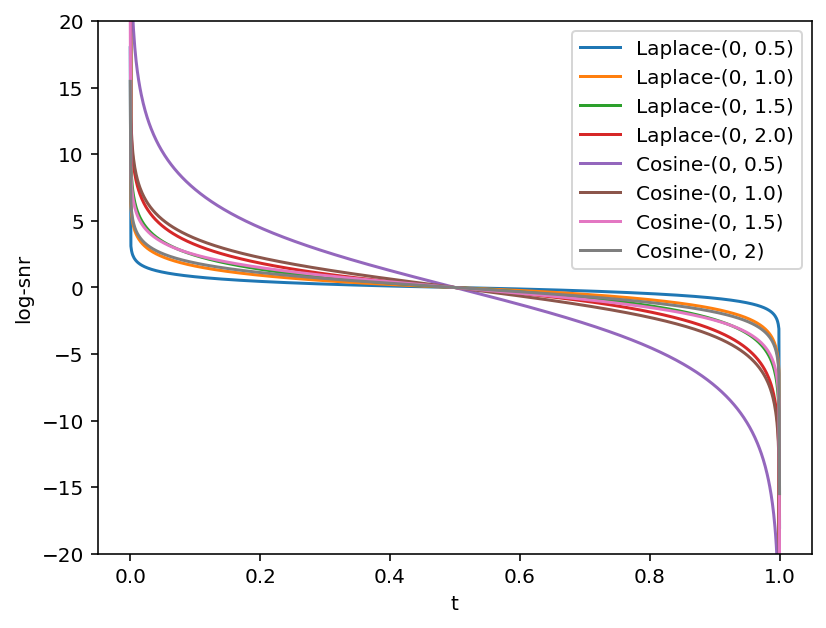

In [4]:
all_t = np.linspace(0, 1, 1000)  # [1:-1]
print(np.max(all_t), np.min(all_t))
all_logsnr_laplace1 = t_to_logsnr_laplace(all_t, 0, 0.5)
all_logsnr_laplace2 = t_to_logsnr_laplace(all_t, 0, 1.0)
all_logsnr_laplace3 = t_to_logsnr_laplace(all_t, 0, 1.5)
all_logsnr_laplace4 = t_to_logsnr_laplace(all_t, 0, 2.0)

all_logsnr_cosine1 = t_to_logsnr_cosine(all_t, s=0.5)
all_logsnr_cosine2 = t_to_logsnr_cosine(all_t, s=1)
all_logsnr_cosine3 = t_to_logsnr_cosine(all_t, s=1.5)
all_logsnr_cosine4 = t_to_logsnr_cosine(all_t, s=2)

plt.plot(all_t, all_logsnr_laplace1)
plt.plot(all_t, all_logsnr_laplace2)
plt.plot(all_t, all_logsnr_laplace3)
plt.plot(all_t, all_logsnr_laplace4)
plt.plot(all_t, all_logsnr_cosine1)
plt.plot(all_t, all_logsnr_cosine2)
plt.plot(all_t, all_logsnr_cosine3)
plt.plot(all_t, all_logsnr_cosine4)
plt.legend(
    [
        "Laplace-(0, 0.5)",
        "Laplace-(0, 1.0)",
        "Laplace-(0, 1.5)",
        "Laplace-(0, 2.0)",
        "Cosine-(0, 0.5)",
        "Cosine-(0, 1.0)",
        "Cosine-(0, 1.5)",
        "Cosine-(0, 2)",
    ]
)
plt.ylim([-20, 20])
plt.ylabel("log-snr")
plt.xlabel("t")
plt.show()

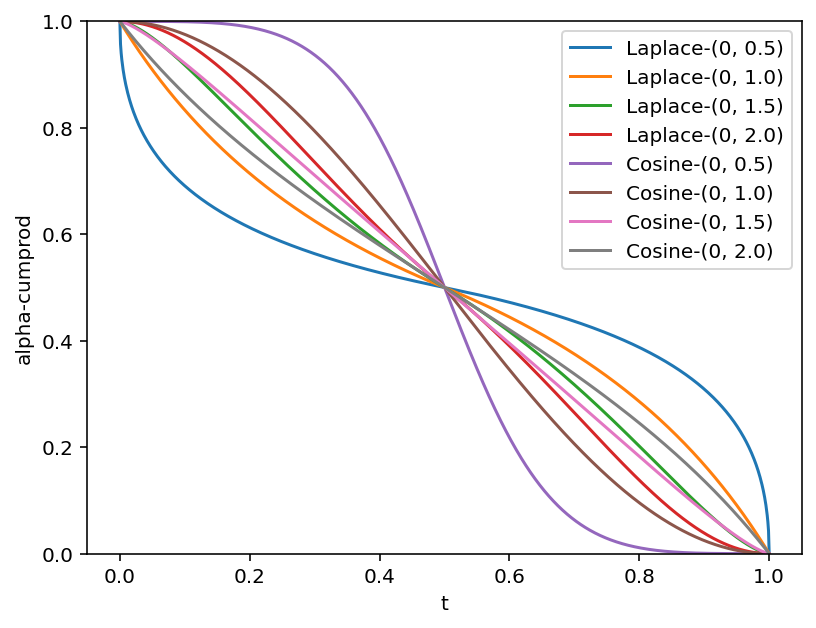

In [5]:
all_alpha_cumprod_laplace1 = logsnr_to_alpha_cumprod(all_logsnr_laplace1)
all_alpha_cumprod_laplace2 = logsnr_to_alpha_cumprod(all_logsnr_laplace2)
all_alpha_cumprod_laplace3 = logsnr_to_alpha_cumprod(all_logsnr_laplace3)
all_alpha_cumprod_laplace4 = logsnr_to_alpha_cumprod(all_logsnr_laplace4)
all_alpha_cumprod_cosine1 = logsnr_to_alpha_cumprod(all_logsnr_cosine1)
all_alpha_cumprod_cosine2 = logsnr_to_alpha_cumprod(all_logsnr_cosine2)
all_alpha_cumprod_cosine3 = logsnr_to_alpha_cumprod(all_logsnr_cosine3)
all_alpha_cumprod_cosine4 = logsnr_to_alpha_cumprod(all_logsnr_cosine4)

plt.plot(all_t, all_alpha_cumprod_laplace1)
plt.plot(all_t, all_alpha_cumprod_laplace2)
plt.plot(all_t, all_alpha_cumprod_laplace3)
plt.plot(all_t, all_alpha_cumprod_laplace4)
plt.plot(all_t, all_alpha_cumprod_cosine1)
plt.plot(all_t, all_alpha_cumprod_cosine2)
plt.plot(all_t, all_alpha_cumprod_cosine3)
plt.plot(all_t, all_alpha_cumprod_cosine4)
plt.legend(
    [
        "Laplace-(0, 0.5)",
        "Laplace-(0, 1.0)",
        "Laplace-(0, 1.5)",
        "Laplace-(0, 2.0)",
        "Cosine-(0, 0.5)",
        "Cosine-(0, 1.0)",
        "Cosine-(0, 1.5)",
        "Cosine-(0, 2.0)",
    ]
)
plt.ylim([0, 1])
plt.ylabel("alpha-cumprod")
plt.xlabel("t")
plt.show()

laplace(0, 0.5) 8191.996 1
laplace(0, 1.0) 67108804.0 5
laplace(0, 1.5) 549755600000.0 24
laplace(0, 2.0) 4503591300000000.0 50
cosine(0, 0.5) 28519397000000.0 195
cosine(0, 1.0) 5340355.5 64
cosine(0, 1.5) 30552.502 21
cosine(0, 2.0) 2310.9211 7


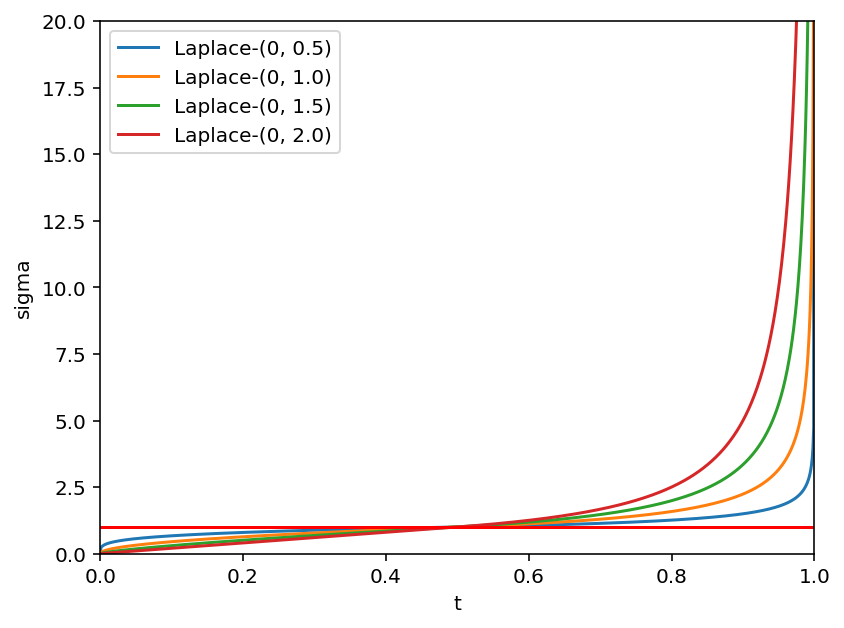

In [6]:
all_sigmas_laplace1 = np.sqrt(
    (1 - all_alpha_cumprod_laplace1) / all_alpha_cumprod_laplace1
)
all_sigmas_laplace2 = np.sqrt(
    (1 - all_alpha_cumprod_laplace2) / all_alpha_cumprod_laplace2
)
all_sigmas_laplace3 = np.sqrt(
    (1 - all_alpha_cumprod_laplace3) / all_alpha_cumprod_laplace3
)
all_sigmas_laplace4 = np.sqrt(
    (1 - all_alpha_cumprod_laplace4) / all_alpha_cumprod_laplace4
)
all_sigmas_cosine1 = np.sqrt(
    (1 - all_alpha_cumprod_cosine1) / all_alpha_cumprod_cosine1
)
all_sigmas_cosine2 = np.sqrt(
    (1 - all_alpha_cumprod_cosine2) / all_alpha_cumprod_cosine2
)
all_sigmas_cosine3 = np.sqrt(
    (1 - all_alpha_cumprod_cosine3) / all_alpha_cumprod_cosine3
)
all_sigmas_cosine4 = np.sqrt(
    (1 - all_alpha_cumprod_cosine4) / all_alpha_cumprod_cosine4
)

print("laplace(0, 0.5)", max(all_sigmas_laplace1), sum(all_sigmas_laplace1 >= 10))
print("laplace(0, 1.0)", max(all_sigmas_laplace2), sum(all_sigmas_laplace2 >= 10))
print("laplace(0, 1.5)", max(all_sigmas_laplace3), sum(all_sigmas_laplace3 >= 10))
print("laplace(0, 2.0)", max(all_sigmas_laplace4), sum(all_sigmas_laplace4 >= 10))
print("cosine(0, 0.5)", max(all_sigmas_cosine1), sum(all_sigmas_cosine1 >= 10))
print("cosine(0, 1.0)", max(all_sigmas_cosine2), sum(all_sigmas_cosine2 >= 10))
print("cosine(0, 1.5)", max(all_sigmas_cosine3), sum(all_sigmas_cosine3 >= 10))
print("cosine(0, 2.0)", max(all_sigmas_cosine4), sum(all_sigmas_cosine4 >= 10))

plt.plot(all_t, all_sigmas_laplace1)
plt.plot(all_t, all_sigmas_laplace2)
plt.plot(all_t, all_sigmas_laplace3)
plt.plot(all_t, all_sigmas_laplace4)
# plt.plot(all_t, all_sigmas_cosine1)
# plt.plot(all_t, all_sigmas_cosine2)
# plt.plot(all_t, all_sigmas_cosine3)
# plt.plot(all_t, all_sigmas_cosine4)
plt.legend(
    [
        "Laplace-(0, 0.5)",
        "Laplace-(0, 1.0)",
        "Laplace-(0, 1.5)",
        "Laplace-(0, 2.0)",
        # "Cosine-(0, 0.5)",
        # "Cosine-(0, 1.0)",
        # "Cosine-(0, 1.5)",
        # "Cosine-(0, 2.0)",
    ]
)
# Draw a line on y=1 for indicating the noise level
plt.plot([-100, 100], [1, 1], color="red")
plt.ylim([0, 20])
plt.xlim([0, 1])
plt.ylabel("sigma")
plt.xlabel("t")
plt.show()